# Brain Tumor Detection

### Necessary imports

Link to the data set: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

In [11]:
# Standard imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image

# Tensorflow imports
import tensorflow as tf
import tensorflow_hub as hub

# Sklearn imports
from sklearn.model_selection import train_test_split

### Preparing the data

In [33]:
def create_data_set():
  """
  Creates pandas dataframe that contains image path and 
  classification if on image is tumor or not.
  """
  path = "C:/Users/Kuba/Downloads/no/"
  images_false = os.listdir(path)
  images_false = [path + image for image in images_false]
  dataframe = pd.DataFrame({"Image_path": images_false,
                            "Is_tumor": False})

  path = "C:/Users/Kuba/Downloads/yes/"
  images_true = os.listdir(path)
  images_true = [path + image  for image in images_true]
  dataframe_true = pd.DataFrame({"Image_path": images_true,
                                 "Is_tumor": True},)
  
  dataframe = dataframe.append(dataframe_true, ignore_index = True)
  return dataframe

df_complete = create_data_set()

C:\Users\Kuba\AppData\Local\Temp\ipykernel_18512\941043555.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append(dataframe_true, ignore_index = True)


In [34]:
df_complete

,Image_path,Is_tumor
0,C:/Users/Kuba/Downloads/no/1 no.jpeg,False
1,C:/Users/Kuba/Downloads/no/10 no.jpg,False
2,C:/Users/Kuba/Downloads/no/11 no.jpg,False
3,C:/Users/Kuba/Downloads/no/12 no.jpg,False
4,C:/Users/Kuba/Downloads/no/13 no.jpg,False
...,...,...
248,C:/Users/Kuba/Downloads/yes/Y95.jpg,True
249,C:/Users/Kuba/Downloads/yes/Y96.jpg,True
250,C:/Users/Kuba/Downloads/yes/Y97.JPG,True
251,C:/Users/Kuba/Downloads/yes/Y98.JPG,True


In [35]:
df_complete.Image_path[0]

'C:/Users/Kuba/Downloads/no/1 no.jpeg'

In [36]:
def preprocess_image(image_path):
  """
  Converts image into tensor.
  """
  image_path = tf.reshape(image_path, [])
  img = tf.io.read_file(image_path)
  img = tf.io.decode_jpeg(img, channels = 3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [224, 224])
  return img

def get_image_label(image, label):
  """
  Returns image and label in tensor format.
  """
  image = preprocess_image(image)
  return image, label
     

In [37]:

df_temp = df_complete
df_temp = df_temp.sample(frac = 1)

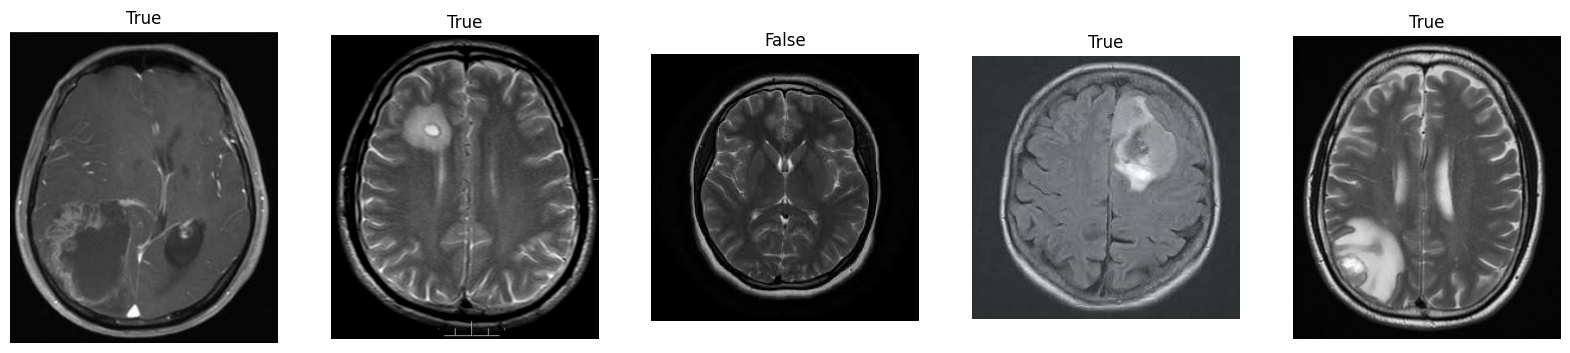

In [38]:

plt.figure(figsize = (20, 10))
i = 1
for x in range(0, 6):
  plt.subplot(1, 5, i)
  z = plt.imread(df_temp.Image_path.iloc[x])
  plt.imshow(z)
  plt.title(df_temp.Is_tumor.iloc[x])
  plt.axis("off")
  i += 1
  if i >= 6:
    i -= 1

In [39]:

X = df_temp.drop("Is_tumor", axis = 1)
y = df_temp["Is_tumor"]

In [40]:

X_test, y_test = X[:20], y[:20]
X_train, X_val, y_train, y_val = train_test_split(X[20:], y[20:], test_size = 0.2)

In [41]:

BATCH_SIZE = 32
NUM_EPOCHS = 64
def create_batch(X, y = None, is_train = False, is_val = False, is_test = False):
  """
  Creates data batches
  """
  if is_train:
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                  tf.constant(y)))
    dataset = dataset.map(get_image_label)
    dataset_batch = dataset.batch(BATCH_SIZE)
    return dataset_batch
  if is_val:
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                  tf.constant(y)))
    dataset = dataset.map(get_image_label)
    dataset_batch = dataset.batch(BATCH_SIZE)
    return dataset_batch
  if is_test:
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                  tf.constant(y)))
    dataset = dataset.map(get_image_label)
    dataset_batch = dataset.batch(BATCH_SIZE)
    return dataset_batch

In [42]:

train_data = create_batch(X_train, y_train, is_train = True)
valid_data = create_batch(X_val, y_val, is_val = True)
test_data = create_batch(X_test, y_test, is_test = True)

In [43]:
train_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.bool, name=None))

### Creating model/callbacks/optimizers

In [46]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                  patience = 3,
                                                  verbose = 1)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir = "C:/Users/Kuba/Downloads/")

In [47]:
def build_model(INPUT_SHAPE = [None, 224, 224, 3], OUTPUT_SHAPE = 1):
  """
  Creates and builds a model
  """
  model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_101/classification/5"),
    tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                          activation = "sigmoid")
  ])

  model.compile(
      loss = tf.keras.losses.BinaryCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )

  model.build(INPUT_SHAPE)
  return model

model = build_model()

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1001)              44677609  
                                                                 
 dense_2 (Dense)             (None, 1)                 1002      
                                                                 
Total params: 44678611 (170.44 MB)
Trainable params: 1002 (3.91 KB)
Non-trainable params: 44677609 (170.43 MB)
_________________________________________________________________


### Training model


In [49]:
model.fit(x = train_data,
          epochs = NUM_EPOCHS,
          validation_data = valid_data,
          validation_freq = 1,
          callbacks = [early_stopping, tensorboard])

Epoch 1/64
6/6 [==============================] - 15s 2s/step - loss: 1.3187 - accuracy: 0.4570 - val_loss: 0.6797 - val_accuracy: 0.6596
Epoch 2/64
6/6 [==============================] - 10s 2s/step - loss: 0.8105 - accuracy: 0.6667 - val_loss: 0.8254 - val_accuracy: 0.5745
Epoch 3/64
6/6 [==============================] - 10s 2s/step - loss: 0.6588 - accuracy: 0.6935 - val_loss: 0.4466 - val_accuracy: 0.7660
Epoch 4/64
6/6 [==============================] - 10s 2s/step - loss: 0.4874 - accuracy: 0.7527 - val_loss: 0.3868 - val_accuracy: 0.8511
Epoch 5/64
6/6 [==============================] - 10s 2s/step - loss: 0.4427 - accuracy: 0.7957 - val_loss: 0.3650 - val_accuracy: 0.8723
Epoch 6/64
6/6 [==============================] - 10s 2s/step - loss: 0.3632 - accuracy: 0.8548 - val_loss: 0.4039 - val_accuracy: 0.7660
Epoch 7/64
6/6 [==============================] - 10s 2s/step - loss: 0.3364 - accuracy: 0.8602 - val_loss: 0.3896 - val_accuracy: 0.8298
Epoch 8/64
6/6 [==================

### Evaluating a model

In [50]:
%tensorboard --logdir=/content/drive/MyDrive/Colab\ Notebooks/braintumordetection/logs

UsageError: Line magic function `%tensorboard` not found.


In [51]:
model.evaluate(test_data)

1/1 [==============================] - 1s 972ms/step - loss: 0.3329 - accuracy: 0.8500


[0.3328922688961029, 0.8500000238418579]

### Saving model

In [52]:
model.save("C:/Users/Kuba/Downloads/")

INFO:tensorflow:Assets written to: C:/Users/Kuba/Downloads/assets


INFO:tensorflow:Assets written to: C:/Users/Kuba/Downloads/assets
